In [130]:
import openmc
import os 
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys 
from PIL import Image
import numpy as np

CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[3]
sys.path.append(str(project_root))

from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import *
from src.utils.pre_processing.pre_processing import *
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS

material = openmc.Materials([B4C_MATERIAL, LEAD_MATERIAL, AIR_MATERIAL, STEEL_MATERIAL])
material.export_to_xml()


In [ ]:
RADIUS = 150.0  # cm
RADIUS_PLUG = 25
PITCH_PLUG = 55
ALTIMETRY_PLUG_STARTING = 300

In [132]:
# b4c_plug_part = openmc.ZCylinder(x0=0.0, y0=0.0, z=0.0, r=25)
height_b4c_plug_part = 50.0  # cm
height_lead_plug_part = 25.0  # cm
b4c_plug_part_cell = openmc.Cell(fill=B4C_MATERIAL, region=-openmc.ZCylinder(x0=0.0, y0=0.0, r=RADIUS_PLUG) &
                                  +openmc.ZPlane(z0=ALTIMETRY_PLUG_STARTING) &
                                  -openmc.ZPlane(z0=ALTIMETRY_PLUG_STARTING + height_b4c_plug_part))
lead_plug_part_cell = openmc.Cell(fill=LEAD_MATERIAL, region=-openmc.ZCylinder(x0=0.0, y0=0.0, r=RADIUS_PLUG) &
                                  +openmc.ZPlane(z0=ALTIMETRY_PLUG_STARTING + height_b4c_plug_part) &
                                  -openmc.ZPlane(z0=ALTIMETRY_PLUG_STARTING + height_b4c_plug_part + height_lead_plug_part))
# ajout cellule acier
plug_universe = openmc.Universe(cells=[lead_plug_part_cell, b4c_plug_part_cell])

all_steel_universe = openmc.Cell(fill=STEEL_MATERIAL)
outer_universe = openmc.Universe(cells=[all_steel_universe])

plug_lat = openmc.HexLattice()
plug_lat.center = (0.0, 0.0)
plug_lat.pitch = (PITCH_PLUG,)
plug_lat.outer = outer_universe
plug_lat.universes = [
    [plug_universe] * 18,  # 3rd ring
    [plug_universe] * 12,  # 2nd ring
    [plug_universe] * 6,   # 1st ring
    [plug_universe],       # Center
]

hex_prism = openmc.model.HexagonalPrism(
    edge_length=194, orientation="y", origin=(0.0, 0.0)
)

plug_assembly_main_cell = openmc.Cell(
    name="plug_assembly_cell",
    fill=plug_lat,
    region=(-hex_prism),
)

air_cell = openmc.Cell(
    name="air_cell",
    fill=AIR_MATERIAL,
    region=+hex_prism & -openmc.Sphere(r=1000),
)

In [133]:
geometry = openmc.Geometry([plug_assembly_main_cell, air_cell])
geometry.export_to_xml()

 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 43
Plot file: plot_openmc_xz.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 0
Width: 1000 1000
Coloring: Cells
Basis: XZ
Pixels: 600 600

 Processing plot 43: plot_openmc_xz.png...


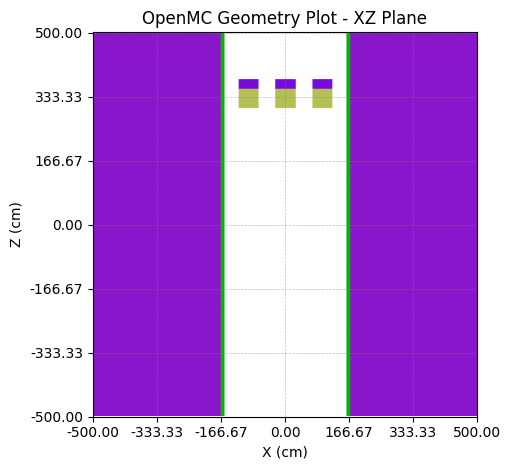

In [134]:
plot_geometry(materials = material, plane="xz", width=1000, height=1000, dpi=500, saving_figure=False, legend_materials=False, color_by="cell")

 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 44
Plot file: plot_openmc_xy.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 365
Width:  500  500
Coloring: Materials
Basis: XY
Pixels: 600 600

 Processing plot 44: plot_openmc_xy.png...


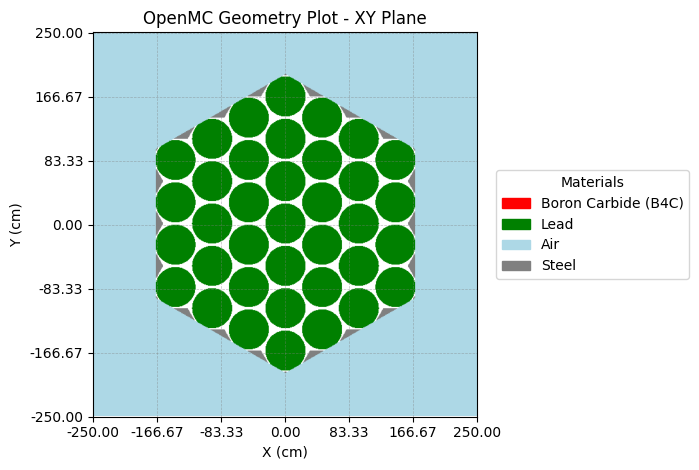

In [135]:
plot_geometry(materials = material, plane="xy",  origin=(0,0, 365), width=500, height=500, dpi=500, saving_figure=False, legend_materials=True, color_by="material")